### Imports

In [137]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sys
import glob
from oak_cli.evaluation.resources.main import ResourcesCSVKeys
from oak_cli.evaluation.addons.flops.main import FLOpsExclusiveCSVKeys, EvaluationRunFLOpsProjectStage
from oak_cli.evaluation.common import get_csv_dir_for_scenario
from oak_cli.evaluation.types import EvaluationScenario
from oak_cli.evaluation.graph_utils import CPU_AND_MEMORY_KEYS, get_evaluation_run_duration_label, adjust_xticks

### Constants

In [138]:
csv_dir = get_csv_dir_for_scenario(EvaluationScenario.FLOPS)

### Settings

In [139]:
USE_MINUTES = True

### Error Handing & Checking

In [140]:
if not csv_dir.exists():
    logger.error(f"{csv_dir} does not exist yet!")
    sys.exit(1)

### Common Graph Configuration

In [141]:
csv_files = glob.glob(f'{csv_dir}/*.csv')
df = pd.concat([pd.read_csv(file) for file in csv_files], ignore_index=True)

# NOTE: The CSV "time-since-start" values are very precise, thus they differ (slightly) between Evaluation-Runs.
# This difference leads to issues when trying to plot them in an aggregated way.
# To fix this we cast the floats to ints instead. I.e. we are looking at whole seconds - which is fine for this concrete use-case.
df[[ResourcesCSVKeys.TIME_SINCE_START.value]] = df[[ResourcesCSVKeys.TIME_SINCE_START.value]].astype(int)

df.set_index(ResourcesCSVKeys.TIME_SINCE_START.value, inplace=True)

if USE_MINUTES:
    df.index = df.index / 60

### Common Graph Styling

In [142]:
sns.set_style("whitegrid")

# Graphs Drawing

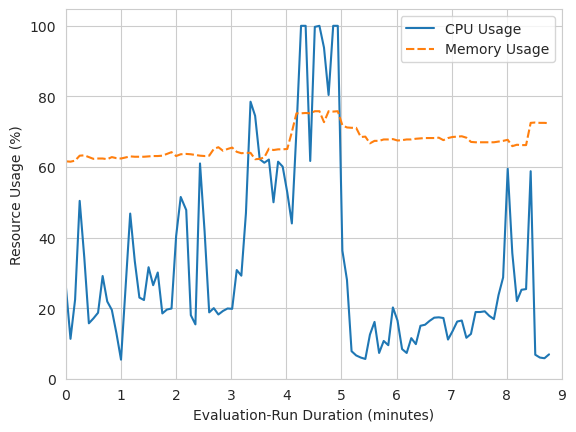

In [143]:
fig, ax = plt.subplots()

sns.lineplot(data=df[CPU_AND_MEMORY_KEYS])

plt.xlabel(get_evaluation_run_duration_label())
plt.ylabel("Resource Usage (%)")
plt.xlim([0, max(df.index)])
plt.ylim(0)
adjust_xticks(ax)

plt.show()

ic| last_stage: ''
ic| row: Evaluation-Run ID                                                    1
         UNIX Timestamp                                       1722272142.474103
         Disk Space Change Since Start                                 5.734375
         Disk Space Change Since Last Measurement                      0.683594
         CPU Usage                                                         11.3
         Memory Usage                                                      61.5
         Network Received Since Start                                   0.69232
         Network Sent Since Start                                      0.716423
         Network Received Compared To Last Measurement                  0.67623
         Network Sent Compared To Last Measurement                     0.688794
         FLOps Project Stage                              FL-Actors Image Build
         Name: 0.08333333333333333, dtype: object
    index: 0.08333333333333333
ic| test: 1
ic| row:

AttributeError: 'Stage_Info' object has no attribute 'stage_name'

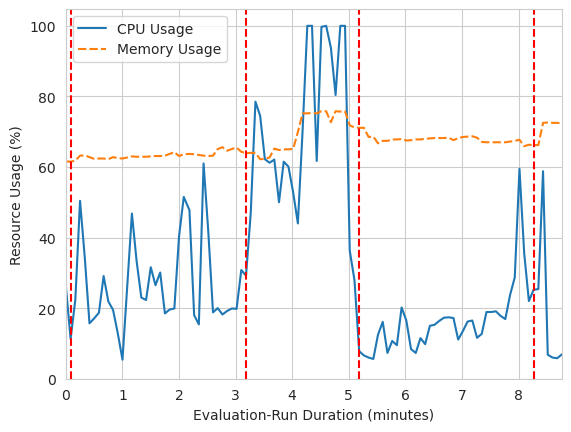

In [144]:
from typing import NamedTuple, List
from icecream import ic
from pydantic import BaseModel
# Create a figure and axis
fig, ax = plt.subplots()

sns.lineplot(data=df[CPU_AND_MEMORY_KEYS])

plt.xlabel(get_evaluation_run_duration_label())
plt.ylabel("Resource Usage (%)")

plt.xlim([0, max(df.index)])
plt.ylim(0)


stage_color_map = {
    "experiment start": "blue",
    "FL-Actors Image Build": "red",
    "FL Training": "green",
    "Trained-Model Image Build": "orange",
    "Deploy Trained-Model": "blue",
}

class Stage_Info(BaseModel):
    stage: EvaluationRunFLOpsProjectStage
    start: float = 0
    end: float = 0


stages: List[Stage_Info] = []

# for index, row in df[df['Stage'] != df['Stage']].iterrows():
#     test += 1
test = 0
last_stage = ""
ic(last_stage)

colors = ['red', 'blue', "green", "yellow", "grey", "purple", "red", "blue"]

for index, row in df.iterrows():
    current_stage = EvaluationRunFLOpsProjectStage(row[FLOpsExclusiveCSVKeys.FLOPS_PROJECT_STAGE.value])

    if last_stage == "":
        last_stage = current_stage
        stages.append(Stage_Info(start=0, stage=current_stage))

    if last_stage != current_stage:
        test += 1
        last_stage = current_stage
        #plt.axvline(x=row['Time since experiment start'], color='r', linestyle='--', ymax=100)  # Red dashed line
        plt.axvline(x=index, color='r', linestyle='--', ymax=100)  # Red dashed line
        #ic(row['Time since experiment start'])
        ic(row, index)

        _last_stage = stages[-1]
        _last_stage.end = float(index)
        ic(test)
        next_stage = Stage_Info(start=index, stage=current_stage)
        stages.append(next_stage)

################

# for index, row in df['Stage'].iterrows():
#     plt.axvline(x=row['Time since experiment start'], color='r', linestyle='--')  # Red dashed line



#ic(df["Stage"].unique())
#plt.axvline(x=190.1971788406372 / 60, color='r', linestyle='--', ymax=100)  # Red dashed line
#plt.axvline(x=1.0, color='r', linestyle='--', ymax=100)  # Red dashed line

#plt.fill_between(range(1,4), range(0,100), color="blue", alpha=0.3)
#plt.fill_between(range(1,4), range(0,100), color="blue", alpha=0.3)
#plt.fill_between(range(1,4), 100, color="blue", alpha=0.15)
#plt.fill_between((1,4), 100, color="blue", alpha=0.15)

#####

stages[-1].end = max(df.index)
for stage_info in stages:
    plt.fill_between((stage_info.start,stage_info.end), 100, color=stage_color_map[stage_info.stage.value], alpha=0.15)    

ic(stages)

plt.xlim([0, max(df.index)])
plt.ylim(0)

plt.show()

KeyError: "None of [Index(['CPU Usage (%)', 'Memory Usage (%)'], dtype='object')] are in the [columns]"

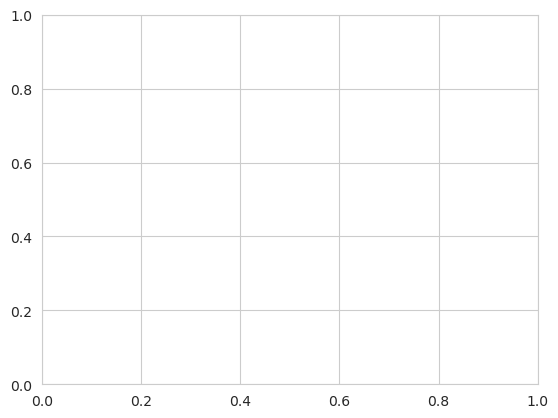

In [ ]:

from typing import NamedTuple, List
from icecream import ic
from pydantic import BaseModel
# Create a figure and axis
fig, ax = plt.subplots()

sns.lineplot(data=df[["CPU Usage (%)", "Memory Usage (%)"]])

plt.xlabel("Experiment Duration " + "(minutes)" if USE_MINUTES else "(seconds)")
plt.ylabel("Resource Usage (%)")

plt.xlim([0, max(df.index)])
plt.ylim(0)


stage_color_map = {
    "experiment start": "blue",
    "FL-Actors Image Build": "red",
    "FL Training": "green",
    "Trained-Model Image Build": "orange",
    "Deploy Trained-Model": "blue",
}

class Stage_Info(BaseModel):
    stage_name: str
    start: float = 0
    end: float = 0


stages: List[Stage_Info] = []

# for index, row in df[df['Stage'] != df['Stage']].iterrows():
#     test += 1
test = 0
last_stage = ""
ic(last_stage)

colors = ['red', 'blue', "green", "yellow", "grey", "purple", "red", "blue"]

for index, row in df.iterrows():
    current_stage = row["Stage"]

    if last_stage == "":
        last_stage = current_stage
        stages.append(Stage_Info(start=0, stage_name=current_stage))

    if last_stage != current_stage:
        test += 1
        last_stage = current_stage
        #plt.axvline(x=row['Time since experiment start'], color='r', linestyle='--', ymax=100)  # Red dashed line
        plt.axvline(x=index, color='r', linestyle='--', ymax=100)  # Red dashed line
        #ic(row['Time since experiment start'])
        ic(row, index)

        _last_stage = stages[-1]
        _last_stage.end = float(index)
        ic(test)
        next_stage = Stage_Info(start=index, stage_name=current_stage)
        stages.append(next_stage)

ic(test)
# for index, row in df['Stage'].iterrows():
#     plt.axvline(x=row['Time since experiment start'], color='r', linestyle='--')  # Red dashed line



#ic(df["Stage"].unique())
#plt.axvline(x=190.1971788406372 / 60, color='r', linestyle='--', ymax=100)  # Red dashed line
#plt.axvline(x=1.0, color='r', linestyle='--', ymax=100)  # Red dashed line

#plt.fill_between(range(1,4), range(0,100), color="blue", alpha=0.3)
#plt.fill_between(range(1,4), range(0,100), color="blue", alpha=0.3)
#plt.fill_between(range(1,4), 100, color="blue", alpha=0.15)
#plt.fill_between((1,4), 100, color="blue", alpha=0.15)
stages[-1].end = max(df.index)
for stage in stages:
    plt.fill_between((stage.start,stage.end), 100, color=stage_color_map[stage.stage_name], alpha=0.15)    

ic(stages)

plt.xlim([0, max(df.index)])
plt.ylim(0)

plt.show()

In [ ]:
plt.figure(figsize=(10, 6)) 
sns.barplot(x="Stage", y="CPU Usage (%)", data=df)

In [ ]:
plt.figure(figsize=(10, 6)) 
sns.boxplot(x="Stage", y="CPU Usage (%)", data=df)

In [ ]:
plt.figure(figsize=(10, 6)) 
sns.barplot(x="Stage", y="Memory Usage (%)", data=df)

In [ ]:
plt.figure(figsize=(10, 6)) 
sns.barplot(x="Stage", y="Memory Usage (%)", data=df)

In [ ]:
plt.figure(figsize=(10, 6)) 
sns.countplot(x="Stage", data=df)

### 0-100 % Resources

In [ ]:
if USE_ROLLING_WINDOW:
    tmp = df[['CPU Usage (%)', 'Memory Usage (%)']].rolling(window=ROLLING_WINDOW_SIZE)
    df[['CPU Usage (%)', 'Memory Usage (%)']] = tmp.mean() if USE_MEAN else tmp.median()

#plt.figure(figsize=(10, 6))  # Adjust the figure size as needed

sns.lineplot(data=df[["CPU Usage (%)", "Memory Usage (%)"]])

#plt.title("Time Series of CPU and Memory Usage")
plt.xlabel("Experiment Duration " + "(minutes)" if USE_MINUTES else "(seconds)")
plt.ylabel("Resource Usage (%)")

plt.xlim([0, max(df.index)])
plt.ylim(0)

plt.show()

### Disk Space Changes

In [ ]:
# plt.figure(figsize=(10, 6))  # Adjust the figure size as needed

if USE_ROLLING_WINDOW:
    tmp = df[["Disk Space change since start"]].rolling(window=ROLLING_WINDOW_SIZE)
    df[["Disk Space change since start"]] = tmp.mean() if USE_MEAN else tmp.median()


df[["Disk Space change since start"]] = df[["Disk Space change since start"]] / 1024
sns.lineplot(data=df[["Disk Space change since start"]])
plt.xlabel("Experiment Duration " + "(minutes)" if USE_MINUTES else "(seconds)")
plt.ylabel("Disk Space Change (GB)")

# Constrain axes e.g. start at 0
plt.xlim([0, max(df.index)])
plt.ylim(0)

plt.show()

In [ ]:
# plt.figure(figsize=(10, 6))  # Adjust the figure size as needed

# if USE_ROLLING_WINDOW:
#     tmp = df[["Disk Space change since start"]].rolling(window=ROLLING_WINDOW_SIZE)
#     df[["Disk Space change since start"]] = tmp.mean() if USE_MEAN else tmp.median()


#df[["Disk Space change since start"]] = df[["Disk Space change since start"]] / 1024
sns.lineplot(data=df[["Next Disk diff"]])
plt.xlabel("Experiment Duration " + "(minutes)" if USE_MINUTES else "(seconds)")
plt.ylabel("Disk Space Change (MB)")

# Constrain axes e.g. start at 0
plt.xlim([0, max(df.index)])
plt.ylim(0)

plt.show()

### Network

### Since Start

In [ ]:
if USE_ROLLING_WINDOW:
    tmp = df[["Net Received Delta compared to start", "Net Set Delta compared to start"]].rolling(window=ROLLING_WINDOW_SIZE)
    df[["Net Received Delta compared to start", "Net Set Delta compared to start"]] = tmp.mean() if USE_MEAN else tmp.median()

sns.lineplot(data=df[["Net Received Delta compared to start", "Net Set Delta compared to start"]] / 1024)
plt.xlabel("Experiment Duration " + "(minutes)" if USE_MINUTES else "(seconds)")
plt.ylabel("Network Change (GB)")

# Constrain axes e.g. start at 0
plt.xlim([0, max(df.index)])
plt.ylim(0)

plt.show()

### Network compared: current vs last

In [ ]:
if USE_ROLLING_WINDOW:
    tmp = df[["Net Received Delta compared to last", "Net Set Delta compared to last"]].rolling(window=ROLLING_WINDOW_SIZE)
    df[["Net Received Delta compared to last", "Net Set Delta compared to last"]] = tmp.mean() if USE_MEAN else tmp.median()

sns.lineplot(data=df[["Net Received Delta compared to last", "Net Set Delta compared to last"]])
plt.xlabel("Experiment Duration " + "(minutes)" if USE_MINUTES else "(seconds)")
plt.ylabel("Network Change (MB)")

# Constrain axes e.g. start at 0
plt.xlim([0, max(df.index)])
plt.ylim(0)

plt.show()